# Test the ADC

## Import some libraries

In [121]:
import numpy as np
import pyaudio
import time
from saleae import automation
import os
import os.path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import cicsim as cs

## Generate the audio stream

In [122]:
def startAudioStream(f,volume):
    p = pyaudio.PyAudio()
    fs = 44000  # sampling rate, Hz, must be integer
    duration = 3.0  # in seconds, may be float
    print(f)
    lsamples = (np.sin(2 * np.pi * np.arange(fs * duration) * f / fs)).astype(np.float32)
    hsamples = -lsamples
    #hsamples = lsamples
    samples = np.array([val for pair in zip(lsamples[0:len(lsamples)-1], hsamples[1:len(hsamples)]) for val in pair])

    output_bytes= (volume * samples).tobytes()

    stream = p.open(format=pyaudio.paFloat32,
                    channels=2,
                    rate=fs,    
                    output=True)

    start_time = time.time()

    stream.write(output_bytes)
    stream.stop_stream()
    stream.close()
    p.terminate()

## Capture from Saleae logic

In [123]:
def captureAnalyzer():
    with automation.Manager.connect(port=10430) as manager:

        device_configuration = automation.LogicDeviceConfiguration(
            enabled_digital_channels=[0, 1, 2, 3,4,5,6,7,8],
            digital_sample_rate=10_000_000,
            digital_threshold_volts=1.8,
        )
        capture_configuration = automation.CaptureConfiguration(
            capture_mode=automation.TimedCaptureMode(duration_seconds=0.1)
        )

        with manager.start_capture(
                device_id='EB3F928DB6DEBCEF',
                device_configuration=device_configuration,
                capture_configuration=capture_configuration) as capture:

            capture.wait()
            analyzer = capture.add_analyzer('Simple Parallel', label=f'Test Analyzer', settings={
                'D0': 0,
                'D1': 1,
                'D2': 2,
                'D3': 3,
                'D4': 4,
                'D5': 5,
                'D6': 6,
                'D7': 7,
                'Clock': 8,
                'Clock State': 'Falling edge',
            })

            output_dir = os.path.join(os.getcwd(), f'data/output-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}')
            os.makedirs(output_dir)
            analyzer_export_filepath = os.path.join(output_dir, 'spi_export.csv')
            print(analyzer_export_filepath)
            capture.legacy_export_analyzer(
                filepath=analyzer_export_filepath,
                analyzer=analyzer,
                radix=automation.RadixType.DECIMAL
            )
    return analyzer_export_filepath

## Post process

In [124]:
        
def toTwosComplement(data):
        if(data > 127):
            data = data - 256
        return data

def paramToStr(data):
    return "A[dB]=%.2f SNDR[dB]=%.2f SNDR[dBFS]=%.2f\nSFDR[dBc]=%.2f ENOB=%.2f ENOBFS=%.2f NBPT=%d" %(data["amp"],data["sndr"],data["sndrfs"],data["sfdr"],data["enob"],data["enobfs"],data["nbpt"])

def plotFFT(fcapture):
    df4 = pd.read_csv(fcapture)
    fs = 200e3
    df4["val"] = df4["Value"].apply(toTwosComplement)
    df4["time"] = df4["Time [s]"]
    df4.set_index("time",inplace=True)
    df4.index = pd.to_datetime(df4.index,unit='s')

    fig,ax = plt.subplots(1,2,figsize=(16,9))
    scc = cs.SimCalc()
    y = df4["val"]/128
    print("STD",df4["val"].std())
    print("MEAN",df4["val"].mean())
    (data,ydB)   = scc.fftWithHanning(y.to_numpy())
    f = np.linspace(0,0.5,num=int(len(ydB)))*fs/1e3
    #ax[0].semilogx(f,ydB,label=paramToStr(data),color="red")
    ax[0].plot(f,ydB,label=paramToStr(data),color="red")
    t = np.linspace(0,len(y),num=len(y))/fs
    ax[1].plot(t,y,marker=".",linestyle="",color="red",markersize=1)
    ax[1].set_ylim(1,-1)
    ax[1].set_ylabel("Normalized Output")
    ax[1].set_xlabel("Time [s]")
    ax[0].set_ylabel("Magnitude [dBFS]")
    ax[0].set_xlabel("Frequency [KHz]")
    ax[0].set_ylim(-120,0)
    ax[0].legend()
    ax[1].set_xlim(0,0.1)
    plt.savefig(fcapture.replace(".csv",".png"))
    plt.show()
    plt.tight_layout()
    


## Run the whole thing

Starting Audio
131
Capture
/Users/wulff/data/2024/tt06-sar/meas/data/output-2025-01-29_12-10-43/spi_export.csv
STD 61.467362171141026
MEAN -0.1629615993153752


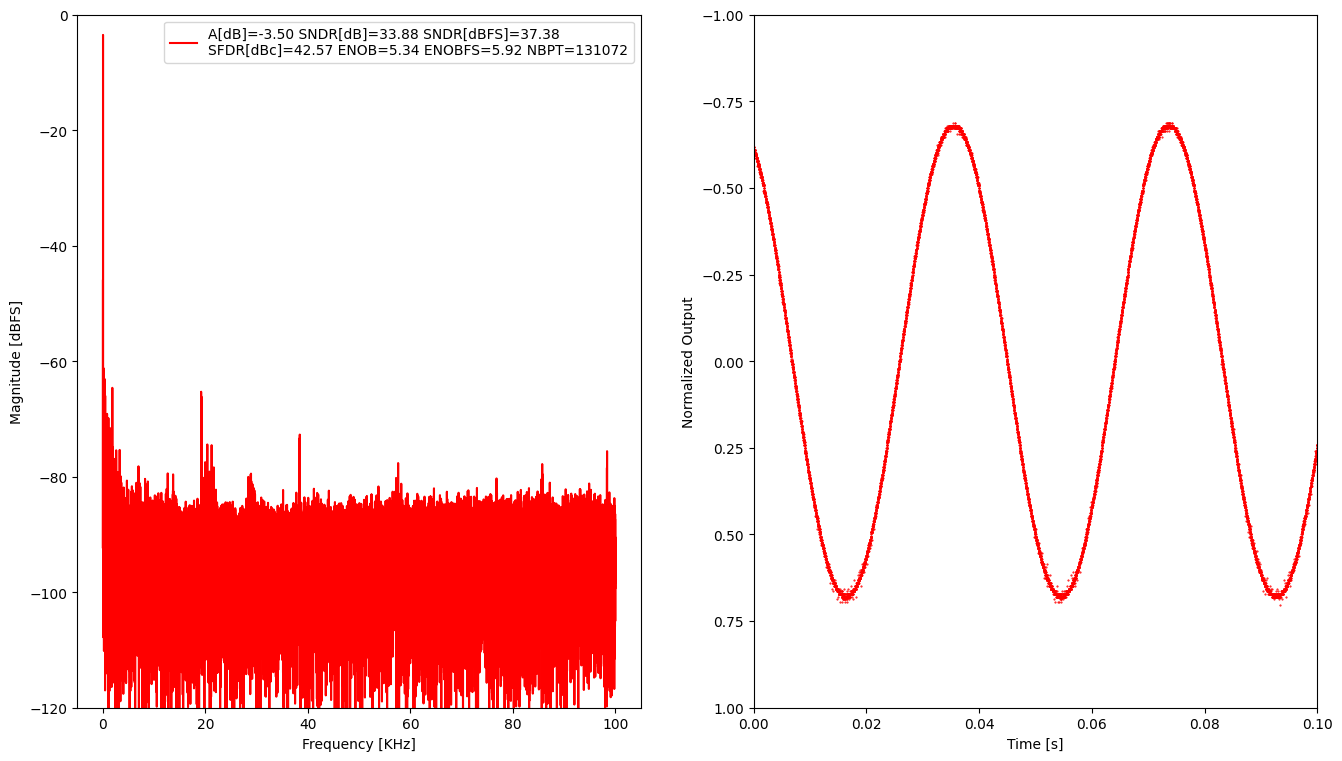

<Figure size 640x480 with 0 Axes>

In [125]:
from threading import Thread
nbpt = 16384
#f =  (nbpt/128-1)/nbpt*200e3
f = 131
volume = 0.3  
print("Starting Audio")
t = Thread(target=startAudioStream, args=[f,volume])
t.start()
time.sleep(1)
print("Capture")
fcapture = captureAnalyzer()
plotFFT(fcapture)